In [2]:
import sys
sys.path.append('/home/wangs/rs/lib')
'''sys.path.append('/home/wangs/rs/lwm/lib')'''
import ff
import pandas as pd
import numpy as np
from multiprocessing import Pool
from multiprocessing import Process
from tqdm import tqdm
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
import extend
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import mplfinance as mpf
import optuna as opt
from IPython.display import HTML
import warnings
import logging
warnings.filterwarnings('ignore')
opt.logging.set_verbosity(opt.logging.WARNING)
import tushare as ts
pro = ts.pro_api('5b6a2c5b17b9572fe089a0802765f8b6434e72c51572718b1d37c302')
import concurrent.futures

其核心逻辑在于被市场非理性追捧的、短期股价波动迅速上升的个股会随着交易行为回归理性而回落至正常的价格区间。

以成交量数据为例, 本文使用 1 分钟频率数据构建了高频成交量波动因子, 其具体构建方法如下：
$$
\begin{gathered}
\sigma_{\text {day }}=\operatorname{std}\left(\left\{v o l_i\right\}\right) \\
\sigma_{\text {vol }}=\frac{\operatorname{std}\left(\left\{\sigma_{\text {day }}\right\}\right)}{\operatorname{mean}\left(\left\{\sigma_{\text {day }}\right\}\right)}
\end{gathered}
$$

In [3]:
code='000001.SZ'
vol_min=ff.read_min(code)['volume']
vol_min.index=pd.to_datetime(vol_min.index)

In [4]:
vol_min.index.date

array([datetime.date(2020, 1, 2), datetime.date(2020, 1, 2),
       datetime.date(2020, 1, 2), ..., datetime.date(2024, 3, 19),
       datetime.date(2024, 3, 19), datetime.date(2024, 3, 19)],
      dtype=object)

In [5]:
def get_vol_day(code):
    vol_min=ff.read_min(code)['volume']
    vol_min.index=pd.to_datetime(vol_min.index)
    vol_day=vol_min.groupby(vol_min.index.date).std()
    return vol_day

In [6]:
def get_vol_factor(code):
    try:
        vol_day=get_vol_day(code)
        vol_factor=vol_day.rolling(window=20).std()/vol_day.rolling(window=20).mean()
        vol_factor.name=code
        return vol_factor
    except:
        pass

In [51]:
codes=ff.cl
with Pool(24) as p:
    res_lst=list(tqdm(p.imap(get_vol_factor,codes),total=len(codes)))

100%|████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [00:51<00:00, 102.56it/s]


In [52]:
res_lst_neu=[x for x in res_lst if x is not None]
vol_factor=pd.concat(res_lst_neu,axis=1).T
vol_factor.columns=pd.to_datetime(vol_factor.columns).strftime('%Y%m%d')
vol_factor=vol_factor.reindex(columns=sorted(vol_factor.columns, key=pd.to_datetime))

In [53]:
mv=ff.read('total_mv')
# 消除市值与行业因素的影响（中性化）
vol_factor_neu = extend.spread_reg(vol_factor*ff.filter0, mv, ind=True) # ind=True为同时进行市值与行业中性化
vol_factor_neu=vol_factor_neu.shift(1,axis=1)

In [54]:
vol_factor_neu.loc[:,'20200206':'20240101']

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20231218,20231219,20231220,20231221,20231222,20231225,20231226,20231227,20231228,20231229
000001.SZ,0.624209,0.595062,0.601606,0.590176,0.572736,0.568531,0.559928,0.533554,0.538620,0.546973,...,0.201990,0.221968,0.238986,0.239887,0.234138,0.265155,0.281150,0.294816,0.320151,0.312265
000002.SZ,0.638802,0.651113,0.647272,0.645797,0.656072,0.654199,0.664565,0.633639,0.620199,0.611280,...,0.716362,0.508269,0.508602,0.431233,0.441945,0.463114,0.482915,0.513587,0.498498,0.491856
000004.SZ,0.523487,0.508920,0.492627,0.490474,0.506842,0.515597,0.520128,0.642115,0.866502,1.006850,...,0.712471,0.739607,0.766821,0.493070,0.425087,0.433212,0.452095,0.453472,0.471264,0.426753
000005.SZ,0.462111,0.460200,0.450441,0.440651,0.456940,0.458945,0.469719,0.472692,0.454424,0.458742,...,1.192873,1.127300,1.109130,1.104179,1.072698,1.051438,0.993745,0.971933,0.935979,0.884481
000006.SZ,0.383959,0.386683,0.379362,0.373141,0.384805,0.380834,0.386368,0.362471,0.377271,0.376153,...,1.056650,1.138001,1.225906,0.627891,0.436778,0.411356,0.440168,0.515031,0.503607,0.510755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601558.SH,0.532040,0.545720,0.535654,0.531859,0.546893,0.523100,0.539999,0.540197,0.529966,0.509945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603157.SH,0.634388,0.602608,0.557691,0.530750,0.523438,0.498663,0.510186,0.530278,0.513312,0.541129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603996.SH,0.546904,0.561176,0.574511,0.540223,0.550160,0.555183,0.552825,0.545298,0.550551,0.551281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688086.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


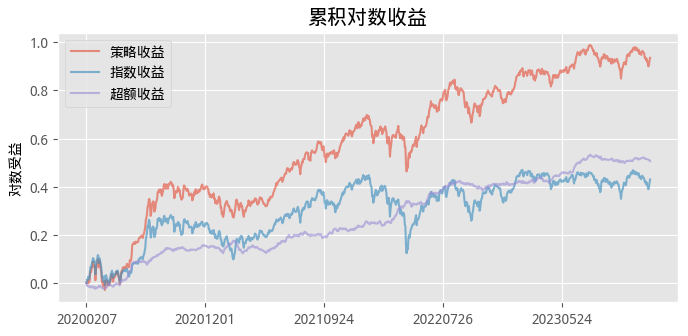

,指数收益,超额收益,策略收益
年化收益率,0.113,0.133,0.246
年化波动率,0.195,0.058,0.204
夏普率,0.580,2.314,1.206
最大回撤,-0.325,-0.053,-0.235
收益回撤比,0.348,2.529,1.049
胜率,0.535,0.540,0.564
盈亏比,0.958,1.252,0.944


In [55]:
result = ff.run((vol_factor_neu * ff.filter0).loc[:,'20200101':'20240101'], positions=100, period=1, fees=0)

## 日内波动与日间波动
（1）直接使用过去 20 个交易日的全部分钟 K 数据计算标准差/均值；       
（2）使用每天的分钟 $\mathrm{K}$ 数据计算日内标准差/均值, 取 20 个交易日平均;        
（3）使用每天的分钟 $\mathrm{K}$ 数据计算日内标准差/均值, 取 20 个交易日标准差;      
(4) 使用每天的分钟 $K$ 数据计算日内标准差, 取 20 个交易日标准差/均值。      
## 数据频率的影响
## 通过差分提取时间序列信息
差分标准化因子        
d}
$$ation}red}

In [61]:
def get_diffvol_day(code):
    vol_min=ff.read_min(code)['volume']
    vol_min.index=pd.to_datetime(vol_min.index)
    vol_day=(vol_min.groupby(vol_min.index.date).diff().groupby(vol_min.index.date).std())/(vol_min.groupby(vol_min.index.date).mean())
    return vol_day
def get_diffvol_factor(code):
    try:
        vol_day=get_diffvol_day(code)
        vol_factor=vol_day.rolling(window=20).mean()
        vol_factor.name=code
        return vol_factor
    except:
        pass
with Pool(24) as p:
    res_lst=list(tqdm(p.imap(get_diffvol_factor,codes),total=len(codes)))
res_lst_neu=[x for x in res_lst if x is not None]
voldiff_factor=pd.concat(res_lst_neu,axis=1).T
voldiff_factor.columns=pd.to_datetime(voldiff_factor.columns).strftime('%Y%m%d')
voldiff_factor=voldiff_factor.reindex(columns=sorted(voldiff_factor.columns, key=pd.to_datetime))
voldiff_factor_neu = extend.spread_reg(voldiff_factor*ff.filter0, mv, ind=True) # ind=True为同时进行市值与行业中性化
voldiff_factor_neu=voldiff_factor_neu.shift(1,axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [00:57<00:00, 92.29it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


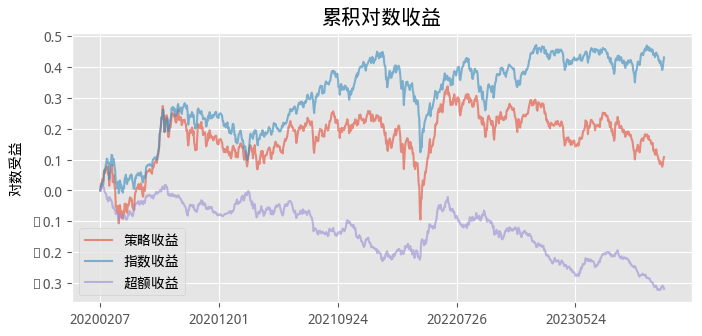

,指数收益,超额收益,策略收益
年化收益率,0.113,-0.084,0.028
年化波动率,0.195,0.105,0.226
夏普率,0.580,-0.799,0.126
最大回撤,-0.325,-0.340,-0.367
收益回撤比,0.348,-0.246,0.077
胜率,0.535,0.479,0.523
盈亏比,0.958,0.951,0.929


In [62]:
result = ff.run((voldiff_factor_neu * ff.filter0).loc[:,'20200101':'20240101'], positions=100, period=1, fees=0)

In [76]:
def get_diffabsvol_day(code):
    vol_min=ff.read_min(code)['volume']
    vol_min.index=pd.to_datetime(vol_min.index)
    vol_dayabs=pd.Series(abs((vol_min.groupby(vol_min.index.date).diff().values)/(vol_min.groupby(vol_min.index.date).mean()[vol_min.index.date].values)),index=vol_min.index)
    vol_day=vol_dayabs.groupby(vol_min.index.date).mean()
    return vol_day
def get_diffabsvol_factor(code):
    try:
        vol_day=get_diffabsvol_day(code)
        vol_factor=vol_day.rolling(window=20).mean()
        vol_factor.name=code
        return vol_factor
    except:
        pass
with Pool(24) as p:
    res_lst=list(tqdm(p.imap(get_diffabsvol_factor,codes),total=len(codes)))
res_lst_neu=[x for x in res_lst if x is not None]
diffabsvol_factor=pd.concat(res_lst_neu,axis=1).T
diffabsvol_factor.columns=pd.to_datetime(diffabsvol_factor.columns).strftime('%Y%m%d')
diffabsvol_factor=diffabsvol_factor.reindex(columns=sorted(diffabsvol_factor.columns, key=pd.to_datetime))
diffabsvol_factor_neu = extend.spread_reg(diffabsvol_factor*ff.filter0, mv, ind=True) # ind=True为同时进行市值与行业中性化
diffabsvol_factor_neu=diffabsvol_factor_neu.shift(1,axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [01:11<00:00, 73.68it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


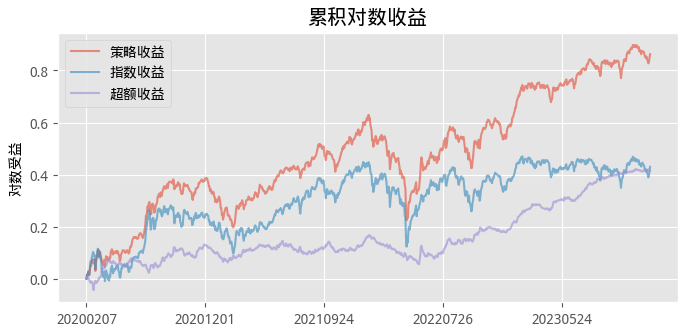

,指数收益,超额收益,策略收益
年化收益率,0.113,0.109,0.227
年化波动率,0.195,0.074,0.184
夏普率,0.580,1.467,1.236
最大回撤,-0.325,-0.111,-0.405
收益回撤比,0.348,0.980,0.561
胜率,0.535,0.517,0.558
盈亏比,0.958,1.198,0.977


In [78]:
result = ff.run(-(diffabsvol_factor_neu * ff.filter0).loc[:,'20200101':'20240101'], positions=100, period=1, fees=0)

## 波峰计数

In [79]:
def get_peakcount_day(code):
    vol_min=ff.read_min(code)['volume']
    vol_min.index=pd.to_datetime(vol_min.index)
    point=vol_min.groupby(vol_min.index.date).mean()+vol_min.groupby(vol_min.index.date).std()
    count=pd.Series(vol_min.values>point[vol_min.index.date].values,index=vol_min.index).replace({True:1,False:0})
    count=((count-count.shift(1))==1)
    count_day=count.groupby(vol_min.index.date).sum()
    return count_day
def get_peakcount_factor(code):
    try:
        count_day=get_peakcount_day(code)
        vol_factor=count_day.rolling(window=20).mean()
        vol_factor.name=code
        return vol_factor
    except:
        pass
with Pool(24) as p:
    res_lst=list(tqdm(p.imap(get_peakcount_factor,codes),total=len(codes)))
res_lst_neu=[x for x in res_lst if x is not None]
peakcount_factor=pd.concat(res_lst_neu,axis=1).T
peakcount_factor.columns=pd.to_datetime(peakcount_factor.columns).strftime('%Y%m%d')
peakcount_factor=peakcount_factor.reindex(columns=sorted(peakcount_factor.columns, key=pd.to_datetime))
peakcount_factor_neu = extend.spread_reg(peakcount_factor*ff.filter0, mv, ind=True) # ind=True为同时进行市值与行业中性化
peakcount_factor_neu=peakcount_factor_neu.shift(1,axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5283/5283 [01:20<00:00, 65.53it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


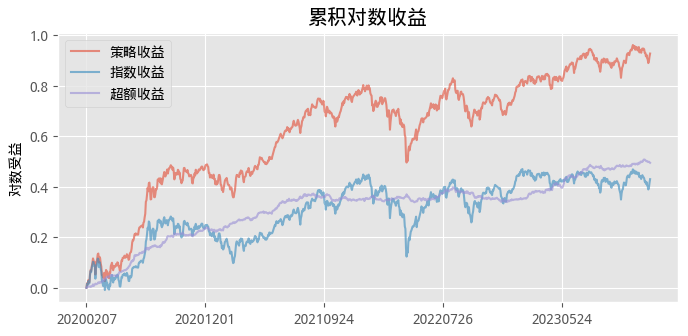

,指数收益,超额收益,策略收益
年化收益率,0.113,0.130,0.244
年化波动率,0.195,0.049,0.197
夏普率,0.580,2.645,1.238
最大回撤,-0.325,-0.059,-0.307
收益回撤比,0.348,2.225,0.795
胜率,0.535,0.554,0.562
盈亏比,0.958,1.252,0.956


In [80]:
result = ff.run((-peakcount_factor_neu * ff.filter0).loc[:,'20170201':'20240101'], positions=100, period=1, fees=0)